In [1]:
import pandas as pd
import numpy as np

# Reading the dataset

Manual inspections of monojet_Zp2000.0_DM_50.0_chan3.csv indicates a row can have at max 65 columns.
This means an event can contain an event in monojet_Zp2000.0_DM_50.0_chan3.csv can contain at max 10 objects.
To accomodate for the additional ';' delimiter at the end of line, we consider an additional column.

In [2]:
max_columns = 65
column_names = ['event ID', 'process ID', 'event weight', 'MET', 'METphi']
n_obj = int((max_columns - 5) / 5) 
for i in range(1, n_obj + 1): #Subtracting 5 because first few columns are meta-data.
    column_names.extend([f'obj{i}', f'E{i}', f'pt{i}', f'eta{i}', f'phi{i}'])
    
column_names.append('sentinel')

In [3]:
df = pd.read_csv('../monojet_Zp2000.0_DM_50.0_chan3.csv', header=None, sep=',|;', 
                 names=column_names, engine='python')

In [4]:
df.drop('sentinel', axis=1, inplace=True)
df.head()

,event ID,process ID,event weight,MET,METphi,obj1,E1,pt1,eta1,phi1,...,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12
0,354,monojet_Zp2000.0_DM_50.0,0.000024,832841.0,-1.22431,b,947383.0,824498.0,-0.523103,1.644210,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,354,monojet_Zp2000.0_DM_50.0,0.000024,732115.0,1.17245,j,1069460.0,751597.0,0.858186,-1.842170,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2,354,monojet_Zp2000.0_DM_50.0,0.000024,1056280.0,-3.06744,j,676000.0,640429.0,0.330450,0.704554,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
3,354,monojet_Zp2000.0_DM_50.0,0.000024,631781.0,1.64181,j,936707.0,616229.0,0.973383,-1.565920,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
4,354,monojet_Zp2000.0_DM_50.0,0.000024,457316.0,-1.87536,j,640313.0,589524.0,0.390749,1.237340,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN


In [5]:
# filter the dataframe to keep only jet particles and their values of E, pt, eta and phi
filtered_particles = list()

for _, row in df.iterrows():
    for i in range(1, n_obj + 1): #iterate over different objects in an event.
        if(row[f'obj{i}'] == 'j'):
            e = row[f'E{i}']
            pt = row[f'pt{i}']
            eta = row[f'eta{i}']
            phi = row[f'phi{i}']
            
            filtered_particles.append([e, pt, eta, phi])
            
data = pd.DataFrame(filtered_particles, columns=['E', 'pt', 'eta', 'phi'])
print(f'The number of entries in the training data: {len(data)}')
print(data.head())

The number of entries in the training data: 22661
          E        pt       eta      phi
0  258722.0  243675.0  0.328962  2.25014
1  520092.0  108590.0 -2.247300 -1.85679
2  383024.0   88405.6  2.145160 -1.95635
3   39507.6   35365.1  0.470460 -1.16445
4  225430.0   26878.2 -2.816080 -2.25938


# Splitting data into train and test

In [6]:
#Splitting the data into train and test splits
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3)

print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print(f'The number of entries in the training data: {len(train)}')
print(f'The number of entries in the validation data: {len(test)}')

Training sample:
              E        pt       eta       phi
20878  439663.0   23641.3 -3.615320  1.175170
20814  407765.0   58975.5  2.620520  0.665193
3263   116917.0   48872.8  1.514560 -0.201870
15712  559754.0  393083.0 -0.886642 -2.068420
19068  557362.0   33117.5  3.515280  0.009702


Testing sample:
               E        pt       eta       phi
17352  1015390.0  108284.0 -2.928150 -0.649529
19519   510893.0   33371.4 -3.420440 -2.661620
8257    143777.0   55284.9 -1.608830 -2.354660
19272   360976.0   60713.7  2.468350  1.822350
276     700033.0  683158.0 -0.132609 -2.288410


The number of entries in the training data: 15862
The number of entries in the validation data: 6799


# Scaling our data

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def apply_log(train_x, test_x, f_name):
    train_x[f_name] = train_x[f_name].apply(lambda x : np.log(1 + x))
    test_x[f_name] = test_x[f_name].apply(lambda x : np.log(1 + x))
    
    return train_x, test_x
    
def apply_scaler(train_x, test_x, f_name, scaler):
    scaler.fit(train_x[f_name].to_numpy().reshape(-1, 1))
    train_x[f_name] = scaler.transform(train_x[f_name].to_numpy().reshape(-1, 1))
    test_x[f_name] = scaler.transform(test_x[f_name].to_numpy().reshape(-1, 1))
    
    return train_x, test_x, scaler
    
def custom_scaler(train, test):
    #Since \eta follows a normal distribution, we can use standardScaler to scale it.
    #For E and pt we can use log(1 + x)
    # for \phi, we can use MinMaxScaling
    
    train_x = train.copy(deep=True)
    test_x = test.copy(deep=True)
    
    standard_scaler_eta = StandardScaler()
    min_max_scaler_e = MinMaxScaler()
    min_max_scaler_pt = MinMaxScaler()
    min_max_scaler_phi = MinMaxScaler()
    
    
    train_x, test_x = apply_log(train_x, test_x, 'E')
    train_x, test_x, min_max_scaler_e = apply_scaler(train_x, test_x, 'E', min_max_scaler_e)
    
    train_x, test_x = apply_log(train_x, test_x, 'pt')
    train_x, test_x, min_max_scaler_pt = apply_scaler(train_x, test_x, 'pt', min_max_scaler_pt)
    
    train_x, test_x, standard_scaler_eta = apply_scaler(train_x, test_x, 'eta', standard_scaler_eta)
    
    train_x, test_x, min_max_scaler_phi = apply_scaler(train_x, test_x, 'phi', min_max_scaler_phi)
    
    return train_x, test_x, min_max_scaler_e, min_max_scaler_pt, standard_scaler_eta, min_max_scaler_phi

In [8]:
def apply_inverse_scaler(data_x, f_name, scaler):
    data_x[f_name] = scaler.inverse_transform(data_x[f_name].to_numpy().reshape(-1, 1))
    
    return data_x 

def apply_exp(data_x, f_name):
    data_x[f_name] = data_x[f_name].apply(lambda x : np.exp(1 + x))
    
    return data_x

def denormalise_data(data, min_max_scaler_e, min_max_scaler_pt, standard_scaler_eta, min_max_scaler_phi):
    
    data_x = data.copy(deep=True)
    data_x = apply_inverse_scaler(data_x, 'E', min_max_scaler_e)
    data_x = apply_exp(data_x, 'E')
    
    data_x = apply_inverse_scaler(data_x, 'pt', min_max_scaler_pt)
    data_x = apply_exp(data_x, 'pt')
    
    data_x = apply_inverse_scaler(data_x, 'eta', standard_scaler_eta)
    
    data_x = apply_inverse_scaler(data_x, 'phi', min_max_scaler_phi)
    
    return data_x

In [9]:
eta_div = 5
phi_div = 3

m_add = 1
m_div = 1.8

pt_div = 1.2
pt_sub = 1.3

def prev_normalize(data):
    data['eta'] = data['eta'] / eta_div
    data['phi'] = data['phi'] / phi_div
    data['E'] = np.log10(data['E'] + m_add) / m_div
    data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div
    
    return data

In [10]:
# 1 for proposed normalizing method, 4 for previous normalizing method
scaling_method = 1

if (scaling_method == 1):
    train_x, test_x, min_max_scaler_e, min_max_scaler_pt, standard_scaler_eta, min_max_scaler_phi \
        = custom_scaler(train, test)

elif (scaling_method == 4):
    train_x = prev_normalize(train)
    test_x = prev_normalize(test)

print('Normalised Training sample:')
print(train_x.head())

print('\n')

print('Normalised Testing sample:')
print(test_x.head())

print('\n')

Normalised Training sample:
              E        pt       eta       phi
20878  0.563189  0.013301 -2.427364  0.687074
20814  0.548523  0.214889  1.740362  0.605904
3263   0.305282  0.173452  1.001193  0.467897
15712  0.610210  0.633211 -0.603651  0.170807
19068  0.609376  0.087632  2.338375  0.501572


Normalised Testing sample:
              E        pt       eta       phi
17352  0.726169  0.348890 -1.968093  0.396645
19519  0.592426  0.089316 -2.297115  0.076390
8257   0.345548  0.200638 -1.086325  0.125247
19272  0.524792  0.221295  1.638659  0.790083
276    0.653754  0.755100 -0.099692  0.135792




# Defining the network

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

from fastai import learner
from fastai.data import core

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

In [12]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

In [13]:
  class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [14]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

Learning rate with the minimum loss: 0.004786301031708717
Learning rate with the steepest gradient: 0.0030199517495930195


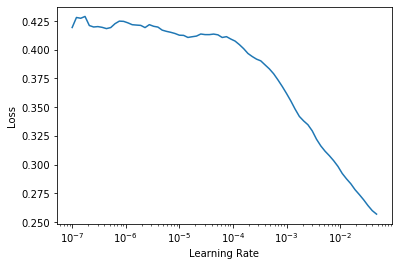

In [15]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

# Training the network

In [ ]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(100, lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.13608141243457794, 0.06950002163648605, '00:00']
[0, 0.13608141243457794, 0.06950002163648605, '00:00']
[1, 0.06602589786052704, 0.029712071642279625, '00:00']
[1, 0.06602589786052704, 0.029712071642279625, '00:00']
[2, 0.03400570526719093, 0.01875658705830574, '00:00']
[2, 0.03400570526719093, 0.01875658705830574, '00:00']
[3, 0.015065553598105907, 0.0043107750825583935, '00:00']
[3, 0.015065553598105907, 0.0043107750825583935, '00:00']
[4, 0.00669979490339756, 0.0029938772786408663, '00:00']
[4, 0.00669979490339756, 0.0029938772786408663, '00:00']
[5, 0.0035504805855453014, 0.0018890954088419676, '00:00']
[5, 0.0035504805855453014, 0.0018890954088419676, '00:00']
[6, 0.0017009227303788066, 0.0005838855286128819, '00:00']
[6, 0.0017009227303788066, 0.0005838855286128819, '00:00']
[7, 0.0007032444118522108, 0.00017976894741877913, '00:00']
[7, 0.0007032444118522108, 0.00017976894741877913, '00:00']
[8, 0.0007069850689731538, 0.000246406183578074, '00:00']
[8, 0.000706985068973153

In [ ]:
recorder.plot_loss()

In [ ]:
learn.validate()